## Predict the age of abalone from categorical and continuous data using deep learning

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Loading Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.545,0.450,0.150,0.7805,0.3795,0.1625,0.216,8
1,M,0.580,0.460,0.155,1.0335,0.4690,0.2225,0.295,10
2,M,0.635,0.495,0.150,1.0810,0.4825,0.2420,0.310,11
3,M,0.600,0.460,0.170,1.1805,0.4560,0.3370,0.329,11
4,M,0.600,0.485,0.175,1.2675,0.4995,0.2815,0.380,13


In [4]:
test_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.255,0.195,0.065,0.0800,0.0315,0.0180,0.027
1,M,0.335,0.255,0.075,0.1635,0.0615,0.0345,0.057
2,M,0.540,0.425,0.120,0.8170,0.2945,0.1530,0.195
3,I,0.355,0.270,0.100,0.2160,0.0830,0.0370,0.075
4,M,0.570,0.460,0.150,1.0375,0.5415,0.2035,0.250


#### 1.Check for missing values:

In [5]:
print(train_df.isnull().sum())

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64


There are no missing values, so you can continue with the subsequent data preprocessing.

### 2.Preprocessing Data

#### 2.1 Separate out categorical and numerical columns and Target Variables

In [6]:
categorical_col = ['Sex']
numerical_cols = ['Length', 'Diameter', 'Height', 'Whole_weight',
                  'Shucked_weight', 'Viscera_weight', 'Shell_weight']

target_col = 'Rings'

#### 2.2 Split into training set and validation set

To prevent data leakage, split the data into training and validation sets before processing them to prevent the model from having "seen" the data distribution of the validation set.

In [7]:
X_cat = train_df[categorical_col]
X_num = train_df[numerical_cols]
y = train_df[target_col].values

In [8]:
X_cat_train, X_cat_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_cat, X_num, y, test_size=0.2, random_state=42
)

The training data is divided into a validation set to evaluate whether it is overfitting.  random_state=42 ensures repeatability.

#### 2.3 One-Hot Encoding for categorical columns and  Standardization for numerical columns

In [9]:
# Initialize encoder and normalizer
ohe = OneHotEncoder(sparse_output=False)  
scaler = StandardScaler()                

# Perform .fit_transform() on the training set
X_cat_train_enc = ohe.fit_transform(X_cat_train)
X_num_train_std = scaler.fit_transform(X_num_train)

#Only .transform() the validation set to avoid leakage
X_cat_val_enc = ohe.transform(X_cat_val)
X_num_val_std = scaler.transform(X_num_val)

#Merge the final feature vector
X_train = np.hstack((X_cat_train_enc, X_num_train_std))
X_val = np.hstack((X_cat_val_enc, X_num_val_std))

Sex is a categorical variable and needs to be converted to numerical form (one-hot encoding).

The other columns are continuous variables and need to be standardized (mean is 0 and standard deviation is 1).

This will make the neural network training more stable.

### 2.5. Build a custom Dataset class

In [10]:
class AbaloneDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


### 2.6.Create DataLoader (mini-batch)

train_loader and val_loader are the mini-batch data iterators we will use during training.

shuffle=True is used to disrupt the training order, which helps the training convergence.

In [11]:
batch_size = 32

train_dataset = AbaloneDataset(X_train, y_train)
val_dataset = AbaloneDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### 3. Approach and Methodology 

We choose to use regression analysis.

Reasons:
- The task goal is to predict the number of "Rings", that is, the age of the abalone.
- Rings in the dataset is an integer variable (title description: "Rings - Integer - 1 to 29").
- The target we predict is a continuous integer value, not a category label (unlike classification, which is a label 0/1/2, etc.).

So this is a typical regression problem, not a classification problem.

Then, we build a neural network that can handle tabular data (mixed categorical + numerical features) and use it to predict the age of abalone using regression.

Use MLP (Multi-layer Perceptron):
- This is a simple but powerful network, which is very suitable for small and medium-sized structured data (such as tabular data).
- Compared with CNN/RNN, it is more suitable for processing fixed-column data.
- The complexity can be adjusted by the number of layers, width, activation function, etc.
- It is easy to add regularization components such as BatchNorm and Dropout.

In [12]:
import torch.nn as nn

class AbaloneMLP(nn.Module):
    def __init__(self, input_dim):
        super(AbaloneMLP, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),             # First hidden layer
            nn.BatchNorm1d(64),                   # Batch normalization to speed up training
            nn.ReLU(),                            # Activation function
            nn.Dropout(p=0.3),                    # Dropout，Preventing Overfitting
            
            nn.Linear(64, 32),                    # Second hidden layer
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(32, 1)                      # Output layer, regressing a continuous value
        )
    
    def forward(self, x):
        return self.net(x)

Now that we have completed the definition of the model structure, we can:

**3.1 Initialize the model**

In [13]:
input_dim = X_train.shape[1]
model = AbaloneMLP(input_dim)

**3.2 Select the optimizer and loss function**

In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

#### Parameter description:

| Parameter name | Meaning |
|--------|------|
| `lr=0.001` | Learning rate, controls update speed |
| `weight_decay=1e-4` | It is the L2 regularization coefficient. The larger the value, the stronger the "penalization of large weights" |

### 4.Results and Evaluation
4.1 Define the training function

In [15]:
import time
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_loss = float('inf')
    best_model_wts = None
    train_losses, val_losses = [], []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Verification phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping Check
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model_wts, 'best_model.pt')  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Visualize the loss curve
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.grid(True)
    plt.show()

    # Load the best model weights (for testing phase)
    model.load_state_dict(torch.load('best_model.pt'))
    return model


4.2 Run the training function

C:\Users\raina\AppData\Roaming\Python\Python310\site-packages\torch\autograd\graph.py:823: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Train Loss: 101.0854, Val Loss: 85.3272
Epoch [2/100], Train Loss: 73.5378, Val Loss: 58.6252
Epoch [3/100], Train Loss: 46.3513, Val Loss: 36.2244
Epoch [4/100], Train Loss: 24.8519, Val Loss: 14.5569
Epoch [5/100], Train Loss: 13.4446, Val Loss: 7.6939
Epoch [6/100], Train Loss: 9.4560, Val Loss: 5.5180
Epoch [7/100], Train Loss: 8.3076, Val Loss: 4.7836
Epoch [8/100], Train Loss: 8.6405, Val Loss: 4.7887
Epoch [9/100], Train Loss: 8.4003, Val Loss: 4.7609
Epoch [10/100], Train Loss: 9.0819, Val Loss: 4.3910
Epoch [11/100], Train Loss: 7.8902, Val Loss: 4.4041
Epoch [12/100], Train Loss: 7.7315, Val Loss: 4.6305
Epoch [13/100], Train Loss: 7.8804, Val Loss: 4.5526
Epoch [14/100], Train Loss: 7.8377, Val Loss: 4.5572
Epoch [15/100], Train Loss: 8.0058, Val Loss: 4.3353
Epoch [16/100], Train Loss: 7.6167, Val Loss: 4.6044
Epoch [17/100], Train Loss: 7.7792, Val Loss: 4.4077
Epoch [18/100], Train Loss: 7.9238, Val Loss: 4.3276
Epoch [19/100], Train Loss: 7.9232, Val Loss:

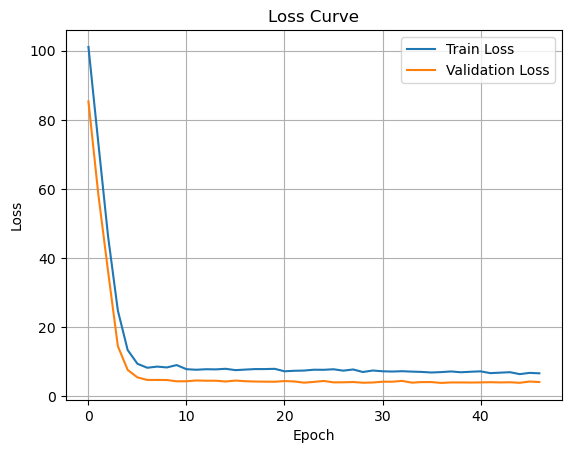

In [16]:
num_epochs = 100
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=10)

1. **Training Loss drops quickly from 101 to around 6.6**
- This shows that the model is learning quickly and the effect is very ideal

2. **Validation Loss drops from 85 to around 4.1**
- At the same time, the validation set effect is also improving, indicating that there is no serious overfitting

3. **Val Loss reaches the best value around Epoch 47**
- Early Stopping helps us stop at the 43th epoch to avoid wasting resources or overfitting

4. **Finally, best_model.pt saves the optimal network parameters**
- Our model has the ability to generate test.csv inference predictions

#### Graphic interpretation:
- The blue line is the training error, and the orange line is the validation error.
- Both drop rapidly and then stabilize.
- The validation error is always slightly lower than the training error, indicating that the model generalizes well and there is no obvious overfitting.

**Loss Curve Interpretation and Validation Behavior**

During training, the validation loss was observed to be consistently lower than the training loss after the initial epochs. While this might seem counterintuitive, it is in fact a common and explainable phenomenon in neural networks trained with regularization. First, dropout (with p=0.3) was applied during training to prevent overfitting by randomly deactivating neurons, effectively injecting noise into the learning process. During validation, however, dropout is turned off, and the full network is evaluated, which can lead to better performance and lower loss. Second, early stopping was employed to halt training once the validation loss plateaued, helping to preserve generalization and avoid overfitting. Third, since the training data was processed in shuffled mini-batches (with shuffle=True) while the validation set was evaluated in full, training loss is more subject to stochastic variation. In contrast, validation loss tends to be smoother and potentially lower. Therefore, the observed validation loss being lower than training loss is not a sign of error, but rather reflects good regularization and generalization behavior.

### 5. Inference code (use test.csv to predict Rings)

In [17]:
# Step 1: Read test.csv
test_df = pd.read_csv('test.csv')

# Step 2: Perform the same preprocessing on the test data as on the training set
X_cat_test = ohe.transform(test_df[categorical_col])
X_num_test = scaler.transform(test_df[numerical_cols])
X_test = np.hstack((X_cat_test, X_num_test))

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Step 3: Load the trained model parameters
model = AbaloneMLP(X_test.shape[1])  
model.load_state_dict(torch.load('best_model.pt'))
model.eval()  

# Step 4: Generate predictions and write to CSV
with torch.no_grad():
    predictions = model(X_test_tensor).numpy().flatten()
    predictions = np.round(predictions).astype(int) 
    predictions = np.clip(predictions, 1, 29)        

output_df = test_df.copy()
output_df['Rings'] = predictions
output_df.to_csv('test_predictions.csv', index=False)
print("Predictions saved to test_predictions.csv")

Predictions saved to test_predictions.csv


### 6.Summary and Justification

### **Abalone Age Prediction using MLP and PyTorch**

### 1. Summary of Approach and Key Novelties

In this assignment, I implemented a regression model to predict the age of abalone using both categorical and numerical features. The model is based on a **Multi-Layer Perceptron (MLP)** architecture using PyTorch. My approach includes the following key design elements:

- **Mixed-feature handling:** Used OneHotEncoding for the categorical `Sex` column and standardization for all numerical features.
- **Regularized model architecture:** Applied **Dropout** and **Batch Normalization** to improve generalization and training stability.
- **Training improvements:** Integrated **Early Stopping** and **L2 regularization (weight decay)** to prevent overfitting.
- **Reproducibility:** Trained model weights are saved as a `.pt` file and used for test inference, ensuring repeatable results.

---

### 2. Justification of Design Choices

#### a) Data Preprocessing
- Categorical feature `Sex` was encoded using `OneHotEncoder` to avoid ordinal bias.
- Numerical features (e.g., `Length`, `Diameter`, etc.) were standardized using `StandardScaler` to ensure balanced gradient updates.
- The train set was split into training and validation (80/20) to monitor generalization performance and detect overfitting.

#### b) Neural Network Design
- I designed a **two-hidden-layer MLP**:
  - First layer: Linear(→64) → BatchNorm → ReLU → Dropout(0.3)
  - Second layer: Linear(→32) → BatchNorm → ReLU → Dropout(0.3)
  - Final layer: Linear(→1), for regression output.
- The activation function used was **ReLU** to introduce non-linearity.
- The hidden layer sizes (64 and 32) were chosen as a reasonable trade-off between model expressiveness and computational simplicity.

#### c) Training Protocol
- Used **Adam optimizer** with a learning rate of 0.001 and `weight_decay=1e-4` (L2 regularization).
- The loss function was **Mean Squared Error (MSE)** since the output is continuous.
- **Early Stopping** was applied with a patience of 10 to prevent overfitting while saving training time.
- Loss curves were plotted to visualize convergence and ensure stable learning.

#### d) Inference Protocol
- After training, the best-performing model weights (lowest validation loss) were saved.
- The same preprocessing steps were applied to `test.csv`.
- In inference mode, the model predicted the number of Rings for each sample, and outputs were rounded to integers in the valid range [1, 29].
- The results were written to a `test_predictions.csv` file.

---

### 3. Challenges and Potential Improvements

**Challenges:**

- **Mixed-type feature handling** required careful and consistent preprocessing. Categorical features were one-hot encoded, and numerical features standardized, while ensuring that no data leakage occurred by fitting preprocessing steps only on the training set.
- **Prediction rounding** was necessary: the model outputs floating-point values, but the target variable (number of rings) must be an integer. I addressed this by rounding the predictions and clipping them to the valid age range \([1, 29]\).
- **Early onset of overfitting** was observed around epoch 15–25. To handle this, I employed early stopping with a patience of 10 based on validation loss.
- **Validation loss lower than training loss**: Interestingly, the validation loss remained slightly lower than the training loss throughout training. While this might seem counterintuitive, it is expected behavior under certain settings. Since dropout (with \(p=0.3\)) is only active during training, the model is intentionally "weakened" to prevent overfitting. In contrast, during validation, dropout is disabled, allowing the full network to be used, which often improves performance. Additionally, the training data is shuffled and passed through mini-batches, introducing stochastic noise, whereas the validation set is evaluated in full, resulting in smoother and potentially lower loss.

**Potential Improvements:**

- Experiment with **deeper or more expressive architectures**, such as residual MLPs or convolutional modules, to improve model capacity.
- Use **K-fold cross-validation** for a more reliable estimate of model generalization.
- Apply **hyperparameter tuning** (e.g., learning rate, dropout rate, hidden dimensions) via grid search or Bayesian optimization.
- Incorporate **feature importance analysis** to better understand which attributes contribute most to the age prediction.


### 7.Additional Experiment – Classification Attempt

Epoch 1, Train Loss: 3.0349, Val Loss: 2.6559
Epoch 2, Train Loss: 2.4835, Val Loss: 2.2740
Epoch 3, Train Loss: 2.2772, Val Loss: 2.1217
Epoch 4, Train Loss: 2.2099, Val Loss: 2.0607
Epoch 5, Train Loss: 2.1560, Val Loss: 2.0191
Epoch 6, Train Loss: 2.1213, Val Loss: 1.9927
Epoch 7, Train Loss: 2.0944, Val Loss: 1.9677
Epoch 8, Train Loss: 2.0832, Val Loss: 1.9528
Epoch 9, Train Loss: 2.0618, Val Loss: 1.9509
Epoch 10, Train Loss: 2.0521, Val Loss: 1.9357
Epoch 11, Train Loss: 2.0470, Val Loss: 1.9382
Epoch 12, Train Loss: 2.0409, Val Loss: 1.9316
Epoch 13, Train Loss: 2.0478, Val Loss: 1.9295
Epoch 14, Train Loss: 2.0295, Val Loss: 1.9227
Epoch 15, Train Loss: 2.0193, Val Loss: 1.9211
Epoch 16, Train Loss: 2.0019, Val Loss: 1.9290
Epoch 17, Train Loss: 2.0158, Val Loss: 1.9134
Epoch 18, Train Loss: 2.0037, Val Loss: 1.9109
Epoch 19, Train Loss: 2.0117, Val Loss: 1.9141
Epoch 20, Train Loss: 2.0000, Val Loss: 1.9142
Epoch 21, Train Loss: 2.0088, Val Loss: 1.9084
Epoch 22, Train Loss: 

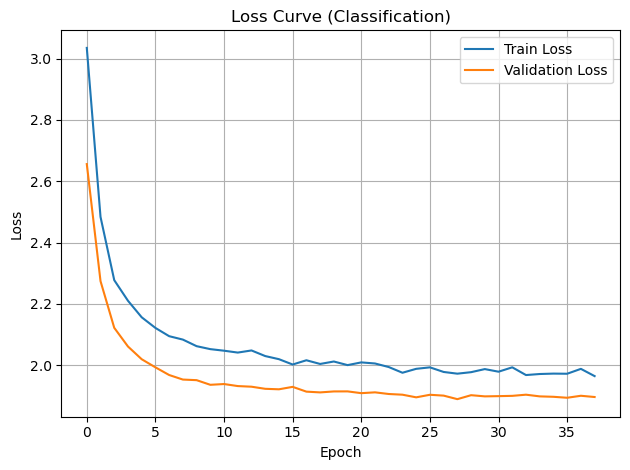

In [28]:
df_class = pd.read_csv("train.csv")

# Labels are adjusted to categorical labels (range 0-28, corresponding to Rings 1~29)
X_cat_class = df_class[['Sex']]
X_num_class = df_class.drop(columns=['Sex', 'Rings'])
y_class = df_class['Rings'].clip(1, 29).values - 1

# Split training and validation sets
X_cat_train_class, X_cat_val_class, X_num_train_class, X_num_val_class, y_train_class, y_val_class = train_test_split(
    X_cat_class, X_num_class, y_class, test_size=0.2, random_state=42
)

# Encoding and standardization
ohe_class = OneHotEncoder(sparse_output=False)
scaler_class = StandardScaler()

X_cat_train_enc_class = ohe_class.fit_transform(X_cat_train_class)
X_cat_val_enc_class = ohe_class.transform(X_cat_val_class)
X_num_train_std_class = scaler_class.fit_transform(X_num_train_class)
X_num_val_std_class = scaler_class.transform(X_num_val_class)

X_train_class = np.hstack((X_cat_train_enc_class, X_num_train_std_class))
X_val_class = np.hstack((X_cat_val_enc_class, X_num_val_std_class))

# Dataset for classification
class AbaloneDatasetClass(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader_class = DataLoader(AbaloneDatasetClass(X_train_class, y_train_class), batch_size=32, shuffle=True)
val_loader_class = DataLoader(AbaloneDatasetClass(X_val_class, y_val_class), batch_size=32)

# modelling
class ClassifierMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 29)  # 29 Classification Output
        )
    def forward(self, x): return self.net(x)

model_class = ClassifierMLP(X_train_class.shape[1])
criterion_class = nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam(model_class.parameters(), lr=0.001, weight_decay=1e-4)

# Training (with Early Stopping)
train_losses_class, val_losses_class = [], []
best_loss_class = float('inf')
patience = 10               
early_stop_counter = 0      

for epoch in range(100):
    model_class.train()
    train_loss = 0
    for xb, yb in train_loader_class:
        optimizer_class.zero_grad()
        pred = model_class(xb)
        loss = criterion_class(pred, yb)
        loss.backward()
        optimizer_class.step()
        train_loss += loss.item() * xb.size(0)
    train_losses_class.append(train_loss / len(train_loader_class.dataset))

    # Verification phase
    model_class.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_class:
            pred = model_class(xb)
            loss = criterion_class(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_losses_class.append(val_loss / len(val_loader_class.dataset))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses_class[-1]:.4f}, Val Loss: {val_losses_class[-1]:.4f}")

    #Early Stopping Decision
    if val_loss < best_loss_class:
        best_loss_class = val_loss
        torch.save(model_class.state_dict(), 'best_model_class.pt')  # Save the best model
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break


#plot loss curve
plt.plot(train_losses_class, label='Train Loss')
plt.plot(val_losses_class, label='Validation Loss')
plt.title("Loss Curve (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Comparison Between Regression and Classification Approaches**  

To explore whether a classification model could outperform regression for abalone age prediction, a separate classification pipeline was implemented. The target variable *Rings* was converted into integer class labels ranging from 0 to 28 (originally 1–29), and a model with 29 output classes was trained using `CrossEntropyLoss`.  

To ensure complete separation from the regression pipeline, distinct preprocessing workflows, dataset classes, model architectures, and optimizers were employed.  

**Observations**:  
- The classification model achieved numerically lower validation loss (e.g., ~1.89) compared to the regression model (e.g., ~4.1). However, this is expected since the loss functions (MSE vs. CrossEntropy) are not directly comparable.  
- Classification outputs required conversion back to numerical form (class label + 1), which introduced a loss of fine-grained resolution in predicted age values.  
- The loss curve exhibited similar patterns to the regression model (validation loss lower than training loss), attributable to dropout and early stopping, rather than indicating overfitting.  

**Conclusion**: Despite lower loss values, the classification model lacked the resolution required for precise age prediction—an inherently regression-oriented task. Therefore, the regression-based pipeline was retained as the final model for inference and submission.  